In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.random_projection import GaussianRandomProjection
from sklearn.random_projection import SparseRandomProjection
##Add decomposed components: PCA / ICA etc.
from sklearn.decomposition import PCA, FastICA, FactorAnalysis
from sklearn.decomposition import TruncatedSVD
import xgboost as xgb
from sklearn.metrics import r2_score, make_scorer
from sklearn.model_selection import StratifiedKFold, KFold
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

## 1. Load

In [2]:
# load data
train = pd.read_csv("../../data/Mercedes_Benz_Greener_Manufacturing/raw/train.csv")
test = pd.read_csv("../../data/Mercedes_Benz_Greener_Manufacturing/raw/test.csv")

In [3]:
print(dt_train_raw.shape, dt_test_raw.shape)

(4209, 378) (4209, 377)


## 2. TargetMean

In [4]:
cols_cat = train.select_dtypes(include = ['object']).columns.values

In [5]:
for c in cols_cat:
    x = train.groupby([c])["y"].mean()
    dt_targetMean_c = pd.DataFrame({c: x.index
                                   , "TargetMean_" + c: x.values})
    train = pd.merge(dt_targetMean_c, train, on = c)
    test = pd.merge(dt_targetMean_c, test, on = c)

In [6]:
train.iloc[:5, :20]

,TargetMean_X8,X8,TargetMean_X6,X6,TargetMean_X5,X5,TargetMean_X4,X4,TargetMean_X3,X3,TargetMean_X2,X2,TargetMean_X1,X1,TargetMean_X0,X0,ID,y,X10,X11
0,100.259,a,97.802524,a,98.672500,aa,100.658293,d,101.959269,c,97.463569,ae,99.837365,b,93.724575,t,8210,90.13,0,0
1,100.259,a,97.802524,a,102.503655,ab,100.658293,d,101.959269,c,96.815967,m,99.837365,b,93.724575,t,2368,88.29,0,0
2,100.259,a,97.802524,a,99.901800,ac,100.658293,d,101.959269,c,99.959925,ak,93.723226,t,103.815000,aw,2722,98.57,0,0
3,100.259,a,97.802524,a,99.901800,ac,100.658293,d,96.564507,f,99.959925,ak,100.725237,l,94.618699,o,2651,88.57,0,0
4,100.259,a,97.802524,a,100.878341,ae,100.658293,d,105.114414,d,103.732453,as,101.868462,s,94.618699,o,3702,85.83,0,0


In [7]:
test.iloc[:5, :10]

,TargetMean_X8,X8,TargetMean_X6,X6,TargetMean_X5,X5,TargetMean_X4,X4,TargetMean_X3,X3
0,100.259,a,97.802524,a,102.343130,c,100.658293,d,101.959269,c
1,100.259,a,97.802524,a,100.082373,k,100.658293,d,102.507477,a
2,100.259,a,97.802524,a,101.768317,m,100.658293,d,101.959269,c
3,100.259,a,97.802524,a,100.285888,s,100.658293,d,100.428672,g
4,100.259,a,103.728421,c,99.782987,v,100.658293,d,102.507477,a


In [8]:
col_targetMean = train.filter(regex = "TargetMean_").columns.values

## 3. Encode

### 3.1 Ordered Label

In [9]:
dt_cat_train_y = train[cols_cat].join(train.y)
dt_cat_test = train[cols_cat].join(train.y)

In [10]:
for c in cols_cat:
    x = list(set(list(train[c].values) + list(test[c].values))) 
    x.sort()
    x.sort(key = len)
    dt_labelEncode_c = pd.DataFrame({"Encode_Label_" + c: [i for i in range(1, (len(x) + 1))]
                                     , c: x})

    train = pd.merge(train, dt_labelEncode_c, on = c)
    test = pd.merge(test, dt_labelEncode_c, on = c)

In [11]:
train.iloc[:5, 0:20]

,TargetMean_X8,X8,TargetMean_X6,X6,TargetMean_X5,X5,TargetMean_X4,X4,TargetMean_X3,X3,TargetMean_X2,X2,TargetMean_X1,X1,TargetMean_X0,X0,ID,y,X10,X11
0,100.259,a,97.802524,a,98.672500,aa,100.658293,d,101.959269,c,97.463569,ae,99.837365,b,93.724575,t,8210,90.13,0,0
1,100.259,a,97.802524,a,99.901800,ac,100.658293,d,101.959269,c,99.959925,ak,93.723226,t,103.815000,aw,2722,98.57,0,0
2,100.259,a,97.802524,a,99.901800,ac,100.658293,d,96.564507,f,99.959925,ak,100.725237,l,94.618699,o,2651,88.57,0,0
3,100.259,a,97.802524,a,100.878341,ae,100.658293,d,105.114414,d,103.732453,as,101.868462,s,94.618699,o,3702,85.83,0,0
4,100.259,a,97.802524,a,102.920147,ag,100.658293,d,101.959269,c,93.803678,f,104.522609,f,95.810588,ai,1919,90.35,0,0


In [12]:
cols_encodeLabel = train.filter(regex = "EncodeLabel_").columns.values

### 3.2 OHE

In [13]:
# dt_all = pd.concat([train.drop(["y"], axis = 1), test])
# dt_cat_onehot = pd.get_dummies(dt_all[cols_cat])
# dict_ohe = {x: "Encode_OHE_" + x for x in dt_cat_onehot.columns.values}
# dt_cat_onehot = dt_cat_onehot.rename(columns = dict_ohe)

In [14]:
train.head()

,TargetMean_X8,X8,TargetMean_X6,X6,TargetMean_X5,X5,TargetMean_X4,X4,TargetMean_X3,X3,...,X384,X385,Encode_Label_X0,Encode_Label_X1,Encode_Label_X2,Encode_Label_X3,Encode_Label_X4,Encode_Label_X5,Encode_Label_X6,Encode_Label_X8
0,100.259,a,97.802524,a,98.672500,aa,100.658293,d,101.959269,c,...,0,0,19,2,26,3,4,22,1,1
1,100.259,a,97.802524,a,99.901800,ac,100.658293,d,101.959269,c,...,0,0,42,20,31,3,4,24,1,1
2,100.259,a,97.802524,a,99.901800,ac,100.658293,d,96.564507,f,...,0,0,15,12,31,6,4,24,1,1
3,100.259,a,97.802524,a,100.878341,ae,100.658293,d,105.114414,d,...,0,0,15,19,39,4,4,26,1,1
4,100.259,a,97.802524,a,102.920147,ag,100.658293,d,101.959269,c,...,0,0,31,6,6,3,4,28,1,1


In [15]:
# train = train.join(dt_cat_onehot.iloc[:train.shape[0]])
# test = test.join(dt_cat_onehot.iloc[train.shape[0]:])

In [16]:
train = train.drop(cols_cat, axis = 1)
test = test.drop(cols_cat, axis = 1)

## 3. Decomposition

In [17]:
n_comp = 15

# tSVD
tsvd = TruncatedSVD(n_components=n_comp, random_state=420)
tsvd_results_train = tsvd.fit_transform(train.drop(["y"], axis=1))
tsvd_results_test = tsvd.transform(test)

# PCA
pca = PCA(n_components=n_comp, random_state=420)
pca2_results_train = pca.fit_transform(train.drop(["y"], axis=1))
pca2_results_test = pca.transform(test)

# ICA
ica = FastICA(n_components=n_comp, random_state=420)
ica2_results_train = ica.fit_transform(train.drop(["y"], axis=1))
ica2_results_test = ica.transform(test)

# GRP
grp = GaussianRandomProjection(n_components=n_comp, eps=0.1, random_state=420)
grp_results_train = grp.fit_transform(train.drop(cols_encodeLabel.tolist() + ["y"], axis=1))
grp_results_test = grp.transform(test)

# SRP
srp = SparseRandomProjection(n_components=n_comp, dense_output=True, random_state=420)
srp_results_train = srp.fit_transform(train.drop(["y"], axis=1))
srp_results_test = srp.transform(test)

# FA
fa = FactorAnalysis(n_components=n_comp, random_state=420)
fa_results_train = fa.fit_transform(train.drop(cols_encodeLabel.tolist() + ["y"], axis=1))
fa_results_test = fa.transform(test.drop(cols_encodeLabel, axis = 1))

In [18]:
#save columns list before adding the decomposition components

usable_columns = list(set(train.columns) - set(['y']))

# Append decomposition components to datasets
for i in range(1, n_comp + 1):
    train['pca_' + str(i)] = pca2_results_train[:, i - 1]
    test['pca_' + str(i)] = pca2_results_test[:, i - 1]

    train['ica_' + str(i)] = ica2_results_train[:, i - 1]
    test['ica_' + str(i)] = ica2_results_test[:, i - 1]

    train['tsvd_' + str(i)] = tsvd_results_train[:, i - 1]
    test['tsvd_' + str(i)] = tsvd_results_test[:, i - 1]

    train['grp_' + str(i)] = grp_results_train[:, i - 1]
    test['grp_' + str(i)] = grp_results_test[:, i - 1]

    train['srp_' + str(i)] = srp_results_train[:, i - 1]
    test['srp_' + str(i)] = srp_results_test[:, i - 1]
    
    train['fa_' + str(i)] = fa_results_train[:, i - 1]
    test['fa_' + str(i)] = fa_results_test[:, i - 1]


In [19]:
train.shape

(4209, 476)

## 4. Feature Engineering

### 4.1 Outlier Maker

In [20]:
dt_featEng = pd.read_csv("../../data/Mercedes_Benz_Greener_Manufacturing/data/dt_all_eng.csv")

In [21]:
train = pd.merge(train, dt_featEng.filter(regex = "Outlier|ID").iloc[:train.shape[0]], on = "ID")
test = pd.merge(test, dt_featEng.filter(regex = "Outlier|ID").iloc[:train.shape[0]], on = "ID")

In [22]:
train.head()

,TargetMean_X8,TargetMean_X6,TargetMean_X5,TargetMean_X4,TargetMean_X3,TargetMean_X2,TargetMean_X1,TargetMean_X0,ID,y,...,pca_15,ica_15,tsvd_15,grp_15,srp_15,fa_15,FeatEng_OutlierMarker_Cat,FeatEng_OutlierMarker_Int,FeatEng_OutlierMarker_All,FeatEng_OutlierMarker_X0
0,100.259,97.802524,98.672500,100.658293,101.959269,97.463569,99.837365,93.724575,8210,90.13,...,1.314945,-0.026278,0.411104,-440.571324,-5.718598,-0.569113,0.125,0.494118,0.456522,0.0
1,100.259,97.802524,99.901800,100.658293,101.959269,99.959925,93.723226,103.815000,2722,98.57,...,2.891924,-0.025520,1.607332,-145.913913,-4.574878,-1.326751,0.125,0.458824,0.423913,0.0
2,100.259,97.802524,99.901800,100.658293,96.564507,99.959925,100.725237,94.618699,2651,88.57,...,1.656735,-0.023742,0.643980,-136.833533,-3.431159,-0.250761,0.250,0.647059,0.608696,0.0
3,100.259,97.802524,100.878341,100.658293,105.114414,103.732453,101.868462,94.618699,3702,85.83,...,2.133261,-0.024573,1.297574,-191.676354,-3.431159,-1.434383,0.125,0.447059,0.413043,0.0
4,100.259,97.802524,102.920147,100.658293,101.959269,93.803678,104.522609,95.810588,1919,90.35,...,1.644623,-0.024945,1.665740,-103.902102,-5.718598,-1.338375,0.250,0.623529,0.586957,0.0


In [ ]:
dt_all_eng.head()

### 4.2 Feature Interaction

In [23]:
train = pd.merge(train, dt_featEng.filter(regex = "FeatEng_FI|ID").iloc[:train.shape[0]], on = "ID")
test = pd.merge(test, dt_featEng.filter(regex = "FeatEng_FI|ID").iloc[:train.shape[0]], on = "ID")

In [24]:
train.head()

,TargetMean_X8,TargetMean_X6,TargetMean_X5,TargetMean_X4,TargetMean_X3,TargetMean_X2,TargetMean_X1,TargetMean_X0,ID,y,...,FeatEng_FI_2way_XOR_X350_X375,FeatEng_FI_2way_XOR_X351_X377,FeatEng_FI_2way_XOR_X356_X377,FeatEng_FI_2way_XOR_X358_X359,FeatEng_FI_2way_XOR_X358_X362,FeatEng_FI_2way_XOR_X358_X375,FeatEng_FI_2way_XOR_X359_X374,FeatEng_FI_2way_XOR_X366_X374,FeatEng_FI_2way_XOR_X366_X384,FeatEng_FI_2way_XOR_X371_X378
0,100.259,97.802524,98.672500,100.658293,101.959269,97.463569,99.837365,93.724575,8210,90.13,...,1,1,0,0,1,0,0,0,0,0
1,100.259,97.802524,99.901800,100.658293,101.959269,99.959925,93.723226,103.815000,2722,98.57,...,1,1,0,1,1,0,0,0,0,0
2,100.259,97.802524,99.901800,100.658293,96.564507,99.959925,100.725237,94.618699,2651,88.57,...,0,0,0,1,1,1,1,1,0,0
3,100.259,97.802524,100.878341,100.658293,105.114414,103.732453,101.868462,94.618699,3702,85.83,...,1,1,0,1,1,1,0,0,0,0
4,100.259,97.802524,102.920147,100.658293,101.959269,93.803678,104.522609,95.810588,1919,90.35,...,1,0,0,0,1,1,0,0,0,0


### 4.3 Sum Binary

In [25]:
train = pd.merge(train, dt_featEng.filter(regex = "FeatEng_SumBin|ID").iloc[:train.shape[0]], on = "ID")
test = pd.merge(test, dt_featEng.filter(regex = "FeatEng_SumBin|ID").iloc[:train.shape[0]], on = "ID")

## 5. xgboost

In [26]:
# r_2 for xgboost
def r_2(preds, dtrain):
    labels = dtrain.get_label()
    return 'score', r2_score(labels, preds)

# make scorer_r2
scorer_r2 = make_scorer(r2_score)

In [27]:
y_train = train['y'].values
y_mean = np.mean(y_train)

In [28]:
params_xgb = {
    'n_trees': 5000,
    'eta': 0.005,
    'max_depth': 2,
    'min_child_weight': 0,
    'subsample': 0.98,
    'objective': 'reg:linear',
    'booster': 'gbtree',
    'eval_metric': 'rmse',
    'base_score': y_mean, # base prediction = mean(target)
    'silent': 1,
}

In [29]:
# xgbDmatrix
dtrain = xgb.DMatrix(train.drop('y', axis=1), y_train)
dtest = xgb.DMatrix(test)

In [30]:
# cv
cv_xgb = xgb.cv(params_xgb, dtrain
                , num_boost_round = 5000
                , nfold = 10
                , feval = r_2, maximize = True, early_stopping_rounds = 50
                , show_stdv = True, verbose_eval = 50, seed = 888)

[0]	train-rmse:12.6441+0.0862764	train-score:0.0056087+0.000125934	test-rmse:12.6226+0.744071	test-score:0.0045036+0.00144664
[50]	train-rmse:11.1561+0.106852	train-score:0.225907+0.00488346	test-rmse:11.1258+0.873672	test-score:0.227862+0.0314353
[100]	train-rmse:10.147+0.124462	train-score:0.359613+0.00768586	test-rmse:10.1209+0.986254	test-score:0.361564+0.0505138
[150]	train-rmse:9.46687+0.1338	train-score:0.442584+0.00883472	test-rmse:9.48815+1.06469	test-score:0.43899+0.0611981
[200]	train-rmse:9.00791+0.134617	train-score:0.49532+0.00885576	test-rmse:9.07488+1.12596	test-score:0.486691+0.0685624
[250]	train-rmse:8.69693+0.129635	train-score:0.529563+0.00828248	test-rmse:8.81187+1.17164	test-score:0.515822+0.0737804
[300]	train-rmse:8.47927+0.122044	train-score:0.552815+0.00751344	test-rmse:8.63992+1.20471	test-score:0.534329+0.0775152
[350]	train-rmse:8.32118+0.11424	train-score:0.569334+0.00677991	test-rmse:8.52613+1.22934	test-score:0.546346+0.0801774
[400]	train-rmse:8.20523+

In [31]:
# train
model_xgb = xgb.train(params_xgb, dtrain, num_boost_round = cv_xgb.shape[0])

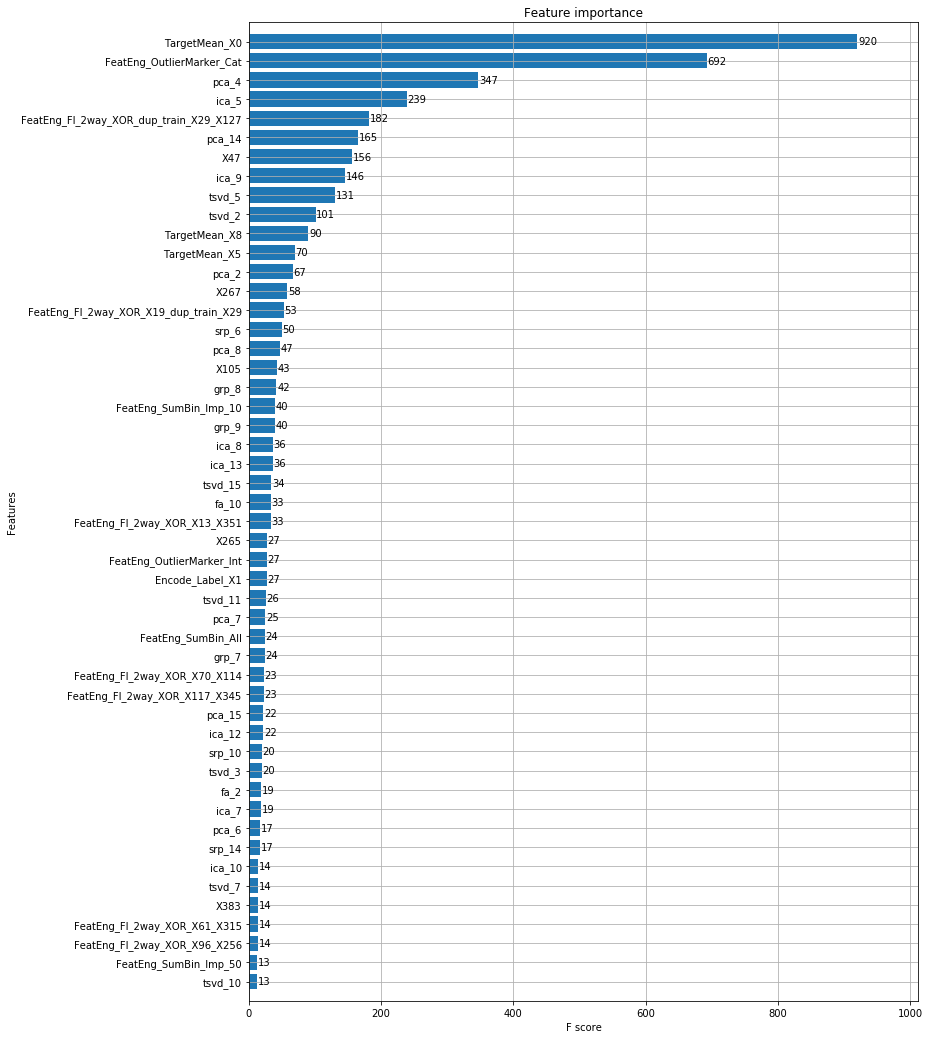

In [32]:
# importance
fig, ax = plt.subplots(figsize = (12,18))
xgb.plot_importance(model_xgb, max_num_features = 50, height = 0.8, ax = ax)
plt.show()